# Systemy uczące się - Zad. dom. 2: Naiwny klassyfikator Bayesa

### Autor rozwiązania: Joanna Cicha, 147963

Ten notebook zawiera dwa zadania związane z klasyfikatorem naiwnego Bayesa, oprócz implementacji zawiera on równie pytania na które trzeba odpowiedzieć.

## Zadanie 1
Zadanie polega na implementacji klasyfikatora naiwnego Bayesa dla zmiennych ciągłych gdzie za rozkłady cechy przyjmij rozkłady normalne.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

Do testowania twojego rozwiązania użyj trzech generatorów danych sztucznych `generate1`, `generate2` oraz `generate3` (funkcje te przyjmują jako argument liczbę elementów do wygenerowania z każdej klasy - domyślnie $N=100$). Sposób ich wywołania jest przedstawiony poniżej:

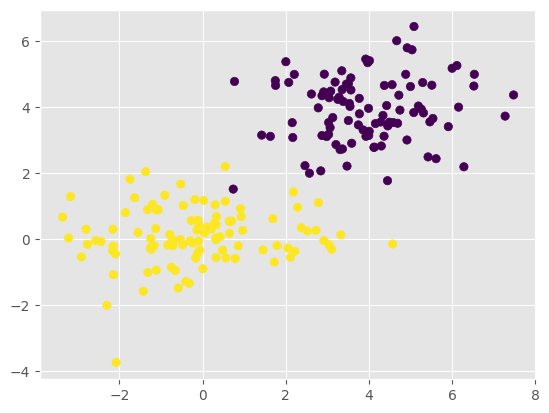

In [3]:
from helpers import generate1, generate2, generate3

X, y = generate1()
plt.scatter(X[:,0], X[:,1], c = y)

W implementacji będzie przydatna klasa `norm` z pakietu `scipy`, która zwraca wartości funkcji gęstości prawdopodobieństwa rozkładu normalnego dla zmiennych ciągłych.

In [4]:
from  scipy.stats import norm

# (X, mean, std)
norm.pdf(5, 0, 1) #gęstość prawd. dla 5 z rozkładu standardowego
norm.logpdf(5, 0, 1) #logarytm gęstości prawd. dla 5 z rozkładu standardowego

-13.418938533204672

Zaimplementuj klasyfikator naiwnego Bayesa dla zmiennych ciągłych. Pamiętaj o zabezpieczniu się przed problemem wynikającym z mnożenia wielu małych liczb (prawdopodobieństw).

In [39]:
class GaussianNaiveBayes():
    def __init__(self):
        self.means = {} 
        self.stds = {} 
        self.class_log_prob = None 
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        # Find unique classes in the target variable
        self.classes = np.unique(y)
        num_classes = len(self.classes)
        
        # Calculate the mean, variance, and prior for each class
        self.class_log_prob = np.zeros(num_classes, dtype=np.float64)
        self.means = np.zeros((num_classes, num_features), dtype=np.float64)
        self.stds = np.zeros((num_classes, num_features), dtype=np.float64)
        
        for i, c in enumerate(self.classes):
            # Filter samples by class
            X_c = X[y == c]

            # Calculate the logarithm of class probability
            self.class_log_prob[i] = np.log(len(X_c) / num_samples)

            # Calculate mean and standard deviation for each feature
            self.means[i, :] = X_c.mean(axis=0)
            self.stds[i, :] = X_c.std(axis=0)
            
    def predict_proba(self, X):
        num_samples, num_features = X.shape

        # Initialize likelihood matrix
        likelihood = np.zeros((num_samples, len(self.classes)))
        
        for i, c in enumerate(self.classes):
            #Get class probability, mean, and standard deviation for the current class
            class_prob = self.class_log_prob[i]
            mean = self.means[i, :]
            std = self.stds[i, :]
            
            # Ensure non-zero standard deviation to avoid division by zero
            eps = 1e-9
            std = np.maximum(std, eps)
            
            # Calculate the logarithm of likelihood for each sample and class
            log_likelihood = - 0.5 * np.sum(np.log(2 * np.pi * std**2)) \
                             - 0.5 * np.sum(((X - mean) / std)**2, axis=1)
            likelihood[:, i] = log_likelihood + class_prob
            
        # Convert logarithmic likelihoods to probabilities
        exp_likelihood = np.exp(likelihood)
        prob = exp_likelihood / np.sum(exp_likelihood, axis=1, keepdims=True)
        
        return prob
    
    def predict(self, X):
        # Predict the class labels for the input samples
        prob = self.predict_proba(X)
        return np.argmax(prob, axis=1)


Przetestuj twój klasyfikator na wygenerowanych wcześniej danych.

In [28]:
gnb = GaussianNaiveBayes()
gnb.fit(X,y)

#Trafność na zbiorze uczącym
np.mean(gnb.predict(X) == y)

0.995

Narysowanie nauczonego klasyfikatora

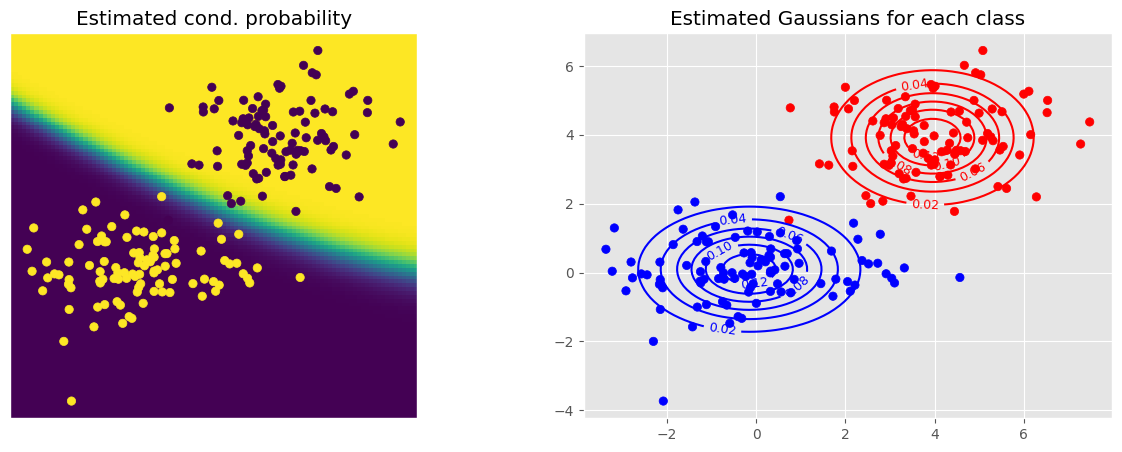

In [29]:
from helpers import plotGaussianBayes
plotGaussianBayes(X, y, gnb)

Użyj funkcji do generowania danych, aby wygenerować zbiór testowy oraz sprawdź na nim trafność klasyfikacji metody.

In [30]:
X_test, y_test = generate1(1000)
np.mean(gnb.predict(X_test) == y_test)

0.989

**Ćwiczenia**
 - Pamiętaj o przetestowaniu Twojego algorytmu dla wszystkich trzech generatorów danych. W których ze zbiorów założenie o warunkowej niezależności zmiennych jest spełnione? Jak brak spełnienia tego założenia wpływa na działanie klasyfikatora?
 - Z pliku `helpers` zaimportuj klasę `GaussianBayes` (identyczna obsługa jak tej zaimplementowanej przez Ciebie). Klasa implementuje algorytm Bayesa bez założenia o niezależności zmiennych (ale z założeniem o normalności rozkładów). Porównaj wyniki - szczególnie dla zbiorów dla których założenie o warunkowej niezależności zmiennych nie jest spełnione.
 - Klasyfikatora `GaussianBayes` nie można wytrenować na zbiorach które mają mniej niż 3 przykłady dla każdej z klas. Jak myślisz dlaczego? Jak ten problem będzie się zmieniał dla zbiorów o wysokiej liczbie cech?
 - Nawet używając klasyfikatora `GaussianBayes`, który zakłada kompletny model zależności i prawidłowy rozkład danych (nasze dane są generowane z rozkładów normalnych) - często nie jest w stanie uzyskać 100% trafności nawet na zbiorze uczącym. Jak myślisz, dlaczego? 
 - Czy gdyby przepisać do klasyfikatora prawdziwe wartości średnich i macierz wariancji-kowariancji cech (z generatora) - uzyskalibyśmy 100% trafność? Co możemy powiedzieć o takim klasyfikatorze? Czy jest możliwe uzyskanie klasyfikatora bardziej trafnego niż taki? 
 
 Odpowiedzi na dwa ostatnie pytania zostaną sprawdzone: wpisz swoje odpowiedzi poniżej.

Ad 4. Współczynnik trafności, zalezy od wielu czynników, które mogą uniemozliwić uzyskanie wartości 100%. Do nich zaliczamy np. zaszumienie danych, bądź złozoność problemu -> gdy dane są zbyt złozone to nie zawsze da się zamodelować problemu za pomocą prostego rozkładu np. gdy istnieją nieliniowe zalezności między cechami. Innym czynnikiem, najczęstszym w dziedzinie jest brak wystarczającej ilości danych, aby model mógł nauczyć się wszystkich drobnych róznic w zbiorze.


Ad 5. Nie zawsze po przepisaniu wartości średnich i macierzy kowariancji cech, mozemy uzyskać 100% trafności. Sprawi to, ze model będzie mieć ułatwione zadanie, natomiast moze to tez oznaczać przetrenowanie modelu, a takze model mogłby zacząć zakładać wiedzę o danych, których rzeczywiście nie ma. Utrudniłoby to zdecydowanie praktyczny aspekt modelu, czyli testowanie go na nowych, nieznanych mu danych. \

Uwzględniając modele nieliniowe, które zakładają bardziej skomplikowane zalezności między danymi, jest mozliwe uzyskanie bardziej trafnego klasyfikatora, badź wykorzystanie innych algorytmów, które lepiej dopasują się do danych.

<span style="color: red;">Z góry przepraszam za błędy w pisowni utrudniajace czytanie, markdown nie pozwala mi z jakiegoś powodu napisać literki 'z' z kropką.</span>

# Zadanie 2
Klasyfikator naiwnego Bayesa często jest używany do klasyfikacji tekstów. Przetestuj działanie algorytmów na podanym rzeczywistym zbiorze danych: 
> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Podany zbiór jest wieloklasowy, więc poniższy kod wybiera z niego podzbiór postów tylko z dwóch tematów.

In [31]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [  'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

vectorizer = TfidfVectorizer(binary=True, use_idf=False, norm=None) # Przekształcenie tekstu na cechy binarne
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors = vectors.toarray()
vectors_test = vectors_test.toarray()

Dokumenty w zbiorze można wyświetlić w następujący sposób.

In [32]:
newsgroups_train.data[0:3]

['From: ab@nova.cc.purdue.edu (Allen B)\nSubject: Re: thining algorithm\nOrganization: Purdue University\nLines: 15\n\nIn article <1q7615INNmi@shelley.u.washington.edu> kshin@stein.u.washington.edu  \n(Kevin Shin) writes:\n> I am trying obtain program to preprocess handwriting characters.\n> Like thining algorithm, graph alogrithm.\n> Do anyone know where I can obtain those?\n\nI usually use "Algorithms for graphics and image processing" by\nTheodosios Pavlidis, but other people here got them same idea and now\n3 of 4 copies in the libraries have been stolen!\n\nAnother reference is "Digital Image Processing" by Gonzalez and\nWintz/Wood, which is widely available but a little expensive ($55\nhere- I just checked today).\n\nab\n',
 "From: stephens@geod.emr.ca (Dave Stephenson)\nSubject: Re: Clementine Science Team Selected\nNntp-Posting-Host: ngis.geod.emr.ca\nOrganization: Dept. of Energy, Mines, and Resources, Ottawa\nLines: 32\n\nnickh@CS.CMU.EDU (Nick Haines) writes:\n\n>In article 

Analogicznie możemy uzyskać dostęp do informacji o klasach.

In [33]:
newsgroups_train.target[0:3]

array([0, 1, 0])

i do "zbinaryzowanego" tekstu

In [34]:
vectors[0:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Wytrenuj klasyfikator Naiwnego Bayesa z rozmywaniem estymat (patrz pakiet `sklearn`) i sprawdż jego trafność na zbiorze uczącym i testowym.

In [36]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Naive Bayes classifier with Laplace smoothing
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict labels for the training and testing sets
y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)

# Accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy on the training set:", train_accuracy)

# Accuracy on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on the testing set:", test_accuracy)


Accuracy on the training set: 0.9523809523809523
Accuracy on the testing set: 0.9555555555555556


**Ćwiczenia**
 - Dlaczego klasyfikator Naiwnego Bayesa dość dobrze sprawdza się do powyższego zadania i analogicznych?
 - Przeanalizuj wartości estymat prawdopodobieństw. Które cechy/słowa są najlepszymi wskaźnikami dla podanych klas? Jakie słowa bardzo słabo wskazują na którąkolwiek z klas?
 - Czy byłoby możliwe wytrenowanie równie skutecznego klasyfikatora z mniejszą liczbą cech? W jaki sposób można by to uzyskać?
 - Analizowany zbiór jest oryginalnie wieloklasowy z tego powodu możemy go wykorzystać do wielu testów wybierając różne pary klas. Pełna lista tematów: 'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
 - Czy są pary tematów dla których ten klasyfikator działa znacząco gorzej?
 - Jakie są zalety stosowania klasyfikatora Bayesa dla tego problemu (i w ogólności)? Czy do tego problemu sprawdziłyby się reguły lub drzewa decyzyjne? Dlaczego?
 
 Odpowiedzi na kropki 1, 3 i 6 wpisz poniżej - zostaną sprawdzone.

Ad 1. Klasyfikator Naiwnego Bayesa sprawdza się do tego zadania i analogicznych z powodu prostoty i  silnego założenia niezalezności cech. Mimo, że to załozenie często nie jest prawdziwe w rzeczywistych danych, Naiwny Bayes często działa dobrze w praktyce, szczególnie dla duzych zbiorów danych. Ponadto jest stosunkowo szybki i łatwy w implementacji.

Ad 3. Tak, byłoby mozliwe wytrenowanie równie skutecznego klasyfikatora z mniejszą liczbą cech. Mozna to osiągnąć poprzez np. rekurencyjną eliminacja cech (RFE) lub selekcją cech na podstawie istotności cech. Przeprowadzenie selekcji cech może pomóc zidentyfikować istotne cechy dla klasyfikacji, co może skutkować lepszą wydajnością modelu i zmniejszeniem kosztów obliczeniowych.
    
Ad 6. Zalety stosowania klasyfikatora Bayesa dla tego problemu i ogólnie to:
    Efektywność: klasyfikator Naiwnego Bayesa jest stosunkowo szybki i posiada niewielką liczbę hiperparametrów do dostrojenia, co ułatwia jego użycie.
    Działa dobrze na duzej liczbie cech: Naiwny Bayes dobrze radzi sobie na dużej liczbie cech, co czyni go odpowiednim wyborem dla problemów z dużą liczbą zmiennych.
    Dobra wydajność dla prostych problemów: Naiwny Bayes często osiąga dobre wyniki dla prostych problemów klasyfikacji, szczególnie gdy założenie niezalezności cech jest stosunkowo spełnione. \
    Z załozenia mozliwym jest zastosowanie go do reguł, bądź drzew decyzyjnych ale moze mieć on trudności w radzeniu sobie z bardziej złozonymi danymi (więcej niz 2 klasy) i będzie podatny na przeuczenie, zwlaszcza dla duzych i złozonych zbiorów danych.

<span style="color: red;">Z góry przepraszam za błędy w pisowni utrudniajace czytanie, markdown nie pozwala mi z jakiegoś powodu napisać literki 'z' z kropką.</span>